In [5]:
import pandas as pd
import numpy as np
from chemicals import iapws95_Psat, iapws95_Tsat, iapws95_rho
from pint import UnitRegistry, Quantity
from plotnine import * 
from warnings import warn
from collections import namedtuple
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# setup pint units
u = UnitRegistry()

# vectorize iapws functions
iapws_Psat = np.vectorize(iapws95_Psat) # input: temperature in K
iapws_Tsat = np.vectorize(iapws95_Tsat) # input: pressure in Pa
iapws_rho = np.vectorize(iapws95_rho) # input: temperature in K, pressure in Pa

# Computing BPD-curves based on well data

For the boiling point depth calculations, we are first going to take a look at some data from a real well. The pressure need to be converted from barg to bara. 

In [6]:
# load real data
url = "https://raw.githubusercontent.com/ICWallis/T21-Tutorial-WellTestAnalysis/main/Data-Temp-Heating37days.csv"
df = pd.read_csv(url)
df['pres_bara'] = df['pres_barg'] - (1 * u.atm).to('bar').magnitude

df

,depth_m,whp_barg,pres_barg,temp_degC,pres_bara
0,0.0,4.019268,3.929268,10.48,2.916018
1,10.5,4.019268,3.929268,10.86,2.916018
2,20.7,4.019268,3.929268,11.63,2.916018
3,30.4,4.019268,3.939268,12.25,2.926018
4,40.3,4.019268,3.949268,12.77,2.936018
...,...,...,...,...,...
89,890.8,4.019268,48.759268,230.79,47.746018
90,900.7,4.019268,49.549268,230.82,48.536018
91,910.5,4.019268,50.359268,230.81,49.346018
92,920.4,4.079268,51.169268,230.56,50.156018


We can then calculate the pure water BPD-curve for this well based on the messured pressure data. For this purpose we are going to use the saturation temperature function from the package *iapws*. Note that this calculation is only possible if you have measured pressure data from a well.

In [7]:
# calculate bpd curve for pure water (iapws)
tsat = iapws_Tsat(df['pres_bara']*1e5) # convert bara to Pa
df['tsat_degC'] = tsat -273.15 

Let's take a look at the results. We can see that the iapws curve is near vertical until below 350 m. This is due to the fact that the water level of the well is below ground level and so the hydrostatic pressure in the well is only increasing once the pressure gauge is recording below the ground level. As we took the pressure data from the well, the BPD-curve is showing the same behaviour.

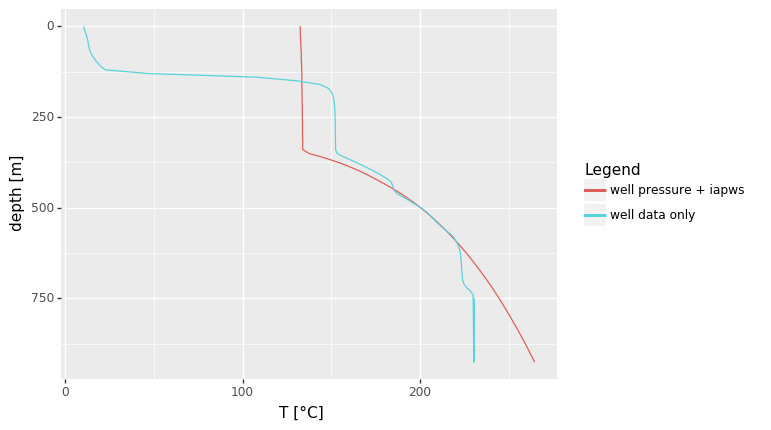

<ggplot: (-9223371851251119624)>

In [8]:
ggplot(aes(y = "depth_m")) +\
    geom_line(aes(x="tsat_degC", colour = "'well pressure + iapws'"), data = df) + \
    geom_line(aes(x = "temp_degC", colour = "'well data only'"), data = df) + \
    scale_y_reverse() + \
    labs(x = "T [°C]", y = "depth [m]", colour = "Legend")

# Computing BPD-curves without well data

In case we don't have measured pressures but still want to compute a BPD-curve, we have to calculate the integral of the hydrostatic pressure from the fluid column in order to obtain the pressure. For this purpose the function bpdc_hydrostatic was written. It uses the IAPWS formalism for calculating density and saturation pressure of the fluid.


In [9]:
def bpdc_hydrostatic(depth, p0=None, method="iapws", units='common'):
    '''
    Function to calculate the hydrostatic boiling point depth curve, similar to:
    Haas Jr., J.L., 1971. The effect of salinity on the maximum thermal gradient 
    of a hydrothermal system at hydrostatic pressure. Econ. Geol. 66, 940–946.

    Parameters
    ----------
    depth : array-like
        An array of depths at which to evaluate the function. 
        Depth intervals should not be bigger than 1 m!
    p : float, optional
        surface pressure of well. The default is 1.01325 bar.
    method : string
        Method to calculate brine density. The default is "iapws".
    units : string or tuple
        String units for depth, pressure, temperature, and density
        respectively. The following are allowed:
        - 'common' to use metres, bar, deg Celsius, and kg/m**3.
        - 'SI' to use metres, Pascal, Kelvin, and kg/m**3.
        - 'Imperial' to use feet, psia, deg Fahrenheit, and g/cm**3.
        - tuple like ('m', 'atm', 'degC', 'g/cm**3') for custom units.

    Returns
    -------
    namedtuple
    '''
    u = UnitRegistry()

    g = 9.81 * u.m / u.s**2

    # Assign units to everything.
    if units == 'SI':
        u_d, u_p, u_t, u_rho = u.m, u.pa, u.K, u.kg/u.m**3
    if units == 'common':
        u_d, u_p, u_t, u_rho = u.m, u.bar, u('degC'), u.kg/u.m**3
    elif units == 'Imperial':
        u_d, u_p, u_t, u_rho = u.ft, u.psi, u('degF'), u.g/u.cm**3
    else:
        u_d, u_p, u_t, u_rho = list(map(u, units))
    
    # Override units with pint Quantity, if possible.
    # And compute the diff array.
    if isinstance(depth, Quantity):
        u_d = depth.units
    else:
        depth = np.asanyarray(depth) * u_d
    depth_diff = np.diff(depth)
    if max(depth_diff.magnitude) > 1:
        warn("Step size of depth interval > 1. This leads to an error propagation in calculated temperatures. Consider reducing the interval size.")
                
    # Override units with pint Quantity, if possible.
    # And deal with not getting a p0 pressure.
    if isinstance(p0, Quantity):
        u_p = p0.units
    elif p0 is None:
        p0 = 101325 * u_p
    else:
        p0 = p0 * u_p  
    p0 = p0.to('Pa')  # Use MPa for calculations (required by IAPWS).

    # Compute using IAPWS option.
    if method == "iapws":
        pressure = np.atleast_1d(p0)
        tsat = iapws95_Tsat(p0.m)
        tsat = tsat //0.01/100 * u.K # round down for iapws95_rho
        rho = iapws95_rho(tsat.m, p0.m) * u.kg / u.m**3
        density = np.atleast_1d(rho)
        print(tsat, pressure, rho)
        
        for i in depth_diff:
            # Calculate new pressure for this step.
            new_p = pressure[-1] + rho * g * i
            pressure = np.append(pressure, new_p)  # Has units.

            # Calculate new temperature for this step.
            # iapws_rho doesn't work at the saturation temperature, so we have to round it down a bit
            new_t = iapws_Tsat(new_p.m)
            new_t = new_t // 0.01 / 100 * u.K# important! round down
            tsat = np.append(tsat, new_t)

            # Calculate new density for next step.
            rho = iapws95_rho(np.floor(new_t.m), np.floor(new_p.m)) * u.kg / u.m**3
            density = np.append(density, rho)
        
        # Finalize units.
        pressure = pressure.to(u_p)
        tsat = tsat.to(u_t)
        density = density.to(u_rho)
        
    # Return a namedtuple to the user to retain units.
    BPD = namedtuple('BPD', ['depth', 'pressure', 'tsat', 'rho'])
    return BPD(depth, pressure, tsat, density)

We can now compute the BPD-curve by only supplying depth data. In the following example, we used the depth from the real well data but you can provide an array of depths, e.g. like `np.linspace(0,1000,1001)`.

In the following code, we also supply the minimum pressure of the real well data as wellhead pressure `p0`. 

In [10]:
# run bpdc calculation
hyd = bpdc_hydrostatic(depth=df['depth_m'], 
                       p0=df["pres_bara"].min(),
                       method='iapws',
                       units=['m', 'bar', 'degC', 'kg/m**3'],
                      )

405.7 kelvin [291601.7731307572] pascal 932.6561112732896 kilogram / meter ** 3


C:\Users\t.hoerbrand\anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Step size of depth interval > 1. This leads to an error propagation in calculated temperatures. Consider reducing the interval size.


You see that a UserWarning was created. This is because the depth intervals we provided to the function were greater than 1 m. We recommend keeping the step size of your depth array by one meter or lower. The function works with an integral using the method of slices, so if your depth intervalls are too big, you will introduce a small error.

Due to the fact that we are using pints for unit control, you have two options to handle the output. Either you retain the units and convert it to a DataFrame, or you remove the units.

In [11]:
# retain units and convert to DataFrame
# hyd_df = pd.DataFrame(hyd).T  # I don't really know why we have to transpose here.
# hyd_df.columns = columns=hyd._fields

# remove units and convert to DataFrame
hyd_df = pd.DataFrame(hyd._asdict())
hyd_df


C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1302: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1672: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


,depth,pressure,tsat,rho
0,0.0,2.916018,132.55,932.656111
1,10.5,3.876700,142.48,924.481978
2,20.7,4.801755,150.31,917.151178
3,30.4,5.674489,156.65,911.475920
4,40.3,6.559705,162.34,905.638191
...,...,...,...,...
89,890.8,73.573942,289.21,734.159288
90,900.7,74.286950,289.87,732.196569
91,910.5,74.990869,290.52,732.332243
92,920.4,75.702103,291.17,730.352941


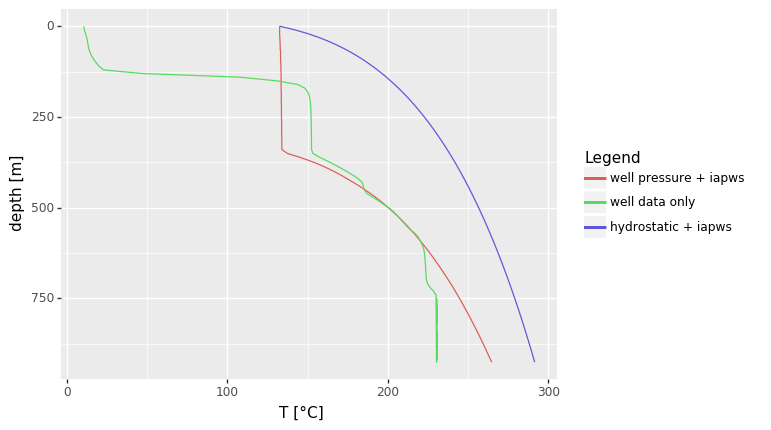

<ggplot: (-9223371851252312604)>

In [12]:
ggplot(aes(y = "depth_m")) +\
    geom_line(aes(x="tsat_degC", colour = "'well pressure + iapws'"), data = df) + \
    geom_line(aes(x = "temp_degC", colour = "'well data only'"), data = df) + \
    geom_line(aes(x = "tsat", y = "depth", colour = "'hydrostatic + iapws'"), data = hyd_df) + \
    scale_y_reverse() + \
    labs(x = "T [°C]", y = "depth [m]", colour = "Legend")

When we plot the data, we see that the hydrostatic curve starts at 0 m and signicifantly deviates from the other curves. This is because the hydrostatic BPD-curve assumes that the water level starts at the first entry of your depth array. We have to tell the function where the water level starts by providing the respective input. Also note that the first temperature of the BPD-curve is 132.5 °C. This is because we provided an initial pressure of 2.91 bar, for which the saturation temperature is 132.5 °C.

Let's shift the hydrostatic BPD-curve to our water level:



In [13]:
# cut depth data to water level and run bpdc calculation
print("Start of water level:", df['depth_m'][35], "m")

hyd = bpdc_hydrostatic(depth=df['depth_m'][35:], 
                       p0=df["pres_bara"].min(),
                       method='iapws',
                       units=['m', 'bar', 'degC', 'kg/m**3'],
                      )

hyd_df = pd.DataFrame(hyd._asdict())

Start of water level: 350.9 m
405.7 kelvin [291601.7731307572] pascal 932.6561112732896 kilogram / meter ** 3


C:\Users\t.hoerbrand\anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Step size of depth interval > 1. This leads to an error propagation in calculated temperatures. Consider reducing the interval size.
C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1302: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1672: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


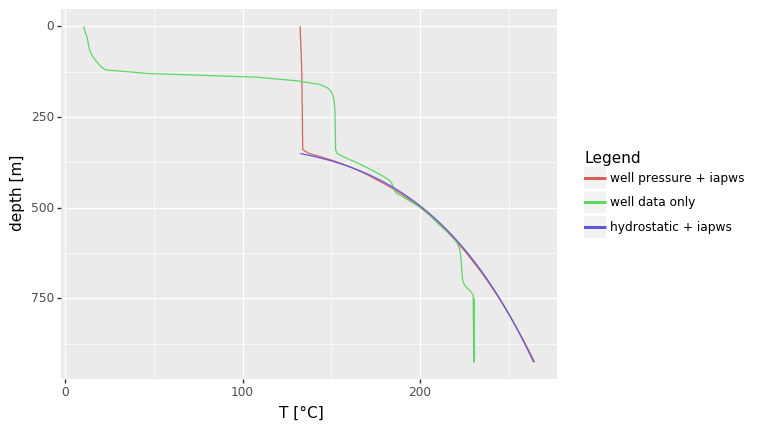

<ggplot: (-9223371851250561312)>

In [14]:
ggplot(aes(y = "depth_m")) +\
    geom_line(aes(x="tsat_degC", colour = "'well pressure + iapws'"), data = df) + \
    geom_line(aes(x = "temp_degC", colour = "'well data only'"), data = df) + \
    geom_line(aes(x = "tsat", y = "depth", colour = "'hydrostatic + iapws'"), data = hyd_df) + \
    scale_y_reverse() + \
    labs(x = "T [°C]", y = "depth [m]", colour = "Legend")

# Using salinity correction for the BPD-curve

Geothermal fluids are never pure water. Mineral content changes the fluid properties and has an impact on the BPD-curves. The main driver for the impact is the change in density, as salinity has a very low impact on the saturation pressure of the brine. If you want to see it yourself before believing it, we'll show you later (see chapter gas correction).

The following function `bpdc_salinity` does the same calculation as `bpdc_hydrostatic` but uses a density correction based on the chemical composition of the geothermal brine. For this correction, we coupled the chemical simulator `PHREEQC` with the BPD calculation, so we first have to setup `PHREEQC` by using the package `phreeqpy`. Using Anaconda on WINDOWS10, the following setup worked:

`conda install pywin32`

`pip install -U phreeqpy`

Then download IPHREEQC:

Link: https://www.usgs.gov/software/phreeqc-version-3

IPHREEQC Module: Windows COM 64-bit: IPhreeqcCOM-3.7.0-15749-x64.msi [4M] - COM server

A word on PHREEQC densities here: For the gas correction we have to couple PHREEQC with the BPD calculations anyway. As PHREEQC is able to calculate densities for a given chemistry, it was chosen for the correction here. For the future we would like to implement other density correlations, but have not finished it yet. Typical density correlations rely on measured data and calculate with NaCl equivalents, which means that in case you have a brine with a high Ca2+ content, you are likely introducing a small error. PHREEQC densities are calculated taking into account every single species in you chemical composition. However this density is not (or only partly) based on correlations, but on the thermodynamic data compiled by Helgeson et al. using a modification of the  Helgeson-Kirkham-Flowers formalism. Before we get lost in thermodynamics - for details on the so-called HKFmoRR equation, see: 

Appelo, C.A.J., 2015. Principles, caveats and improvements in databases for calculating hydrogeochemical reactions in saline waters from 0 to 200°C and 1 to 1000atm. Appl. Geochemistry 55, 62–71. https://doi.org/10.1016/j.apgeochem.2014.11.007

So after setting up PHREEQC, we have to define a couple of functions in order to make and run chemical models: `make_chemical_model`, `run_chemical_model`, `get_chemical_output`. These functions are then used in `bpdc_salinity` which is also define beloww.


In [111]:
import phreeqpy.iphreeqc.phreeqc_com as phreeqc_mod



def make_chemical_model(chem_ions, chem_gas_mol, t, p, chem_units = "mg/L", pH = 7):
    '''  
    Function to create a PHREEQC model for a brine to calculate the boiling point and density.

    Parameters
    ----------
    chem_ions_mol : pd.DataFrame
        Contains the ionic composition of the fluid with the chemical units defined in chem_units.
    chem_gas_mol : pd.DataFrame
        Contains the gas amount of the individual gases in mol/kgw.
    t : float
        Temperature [°C]
    p : float
        Pressure [bara]
    chem_units : string, optional
        Units in which the chemical composition is supplied. 
        Options are "mg/L" (equal to ppm), "mol/L" (molarity) and "mol/kgw" (molality). 
        The default is "mg/L" which is equal to ppm.
    pH : float, optional
        DESCRIPTION. The default is 7.
        
    Returns
    -------
    chemical model string
    
    '''
    
    chemical_model = """
        TITLE 
        SOLUTION 1
        """ + \
        "\n units " + chem_units + \
        "\n temp " + str(t) + \
        "\n pH " + str(pH) + \
        "\n pressure " + str(p) + \
        "\n Na " + str(chem_ions["Na"][0]) + \
        "\n K " + str(chem_ions["K"][0]) + \
        "\n Ca " + str(chem_ions["Ca"][0]) + \
        "\n S(6) " + str(chem_ions["SO4"][0]) + \
        "\n HCO3 " + str(chem_ions["HCO3"][0]) + \
        "\n Cl " + str(chem_ions["Cl"][0]) + \
        "\n EQUILIBRIUM_PHASES"   + \
        "\n Mtg(g) 10 " + str(chem_gas_mol["CH4"][0]) + \
        "\n Ntg(g) 10 " + str(chem_gas_mol["N2"][0]) + \
        "\n Hdg(g) 10 " + str(chem_gas_mol["H2"][0]) + \
        "\n CO2(g) 10 " + str(chem_gas_mol["CO2"][0]) + """
        SELECTED_OUTPUT
        -reset false
        USER_PUNCH
        -headings CO2 N2 CH4 H2O H2 rho t
        10 PUNCH 10^SI("CO2(g)") * 1.01325 /PR_PHI("CO2(g)")
        20 PUNCH 10^SI("Ntg(g)") * 1.01325 /PR_PHI("Ntg(g)")
        30 PUNCH 10^SI("Mtg(g)") * 1.01325 /PR_PHI("Mtg(g)")
        40 PUNCH 10^SI("H2O(g)") * 1.01325 /PR_PHI("H2O(g)")
        50 PUNCH 10^SI("Hdg(g)") * 1.01325 /PR_PHI("Hdg(g)")
        60 PUNCH RHO*1000
        70 PUNCH TC
        END
        """
        
    return chemical_model
      
  

def run_chemcial_model(chemical_model, database_path):  
    """
    

    Parameters
    ----------
    chemical_model : string
        PHREEQC input string, generated with "make_chemical_model"
    database_path : string
        Path to thermodynamic database used with phreeqc, e.g. r"C:/phreeqc/database/phreeqc.dat"

    Returns
    -------
    output : tuple
        results of PHREEQC simulation (selected output)
        Contains header in first row [0], intialization in second row [1] and results in third row [2]

    """
    
    # Initialize IPhreeqc
    phreeqc = phreeqc_mod.IPhreeqc()
    
    # Load thermodynamic database provided by phreeqc
    phreeqc.load_database(database_path)
    
    # Run chemical model
    phreeqc.run_string(chemical_model)  

    # Get selected output    
    #components = phreeqc.get_component_list()
    output = phreeqc.get_selected_output_array()
    
    return output


def get_chemical_properties(output):
    """
    Format simulation results from "run_chemical_model".

    Parameters
    ----------
    output : tuple
        Results of function "run_chemical_model".

    Returns
    -------
    partial_pressure : float
        Sum of partial pressures [atm].
    rho_phreeqc : float
        Denisty in [kg/m**3].
    t_phreeqc : float
        Temperature in [°C]

    """
    
    # Indices / output format provided with the USER_PUNCH block in function "make_chemical_model"
    partial_pressure = sum(output[2][0:5]) # why the hell is it not 0:4 here? Whatever it works...
    partial_pressure = partial_pressure
    rho_phreeqc = output[2][5]
    t_phreeqc = output[2][6]
    
    return partial_pressure, rho_phreeqc, t_phreeqc

def bpdc_salinity(depth, p0, chem_ions, chem_units = "mol/kgw", 
                  method = "driesner", database_path = r"./data/database/pitzer.dat",  units='common'):
    '''
    Function to calculate the hydrostatic boiling point depth curve, similar to:
    Haas Jr., J.L., 1971. The effect of salinity on the maximum thermal gradient 
    of a hydrothermal system at hydrostatic pressure. Econ. Geol. 66, 940–946.

    Parameters
    ----------
    depth : array-like
        An array of depths at which to evaluate the function. 
        Depth intervals should not be bigger than 1 m!
    p0 : float
        Surface pressure of well.
    chem_ions: DataFrame
        Contains major ions of brine in columns with the names of the ions.
        Example: pd.DataFrame([[0.5, 0.5 , 0.5, 0.5, 0.5, 0.5]], columns = ['Na', 'K', 'Ca', 'Cl', 'SO4', 'HCO3'])
    method : string
        Method to calculate brine density. The following are allowed:
        - 'driesner': Converts salinity to NaCl equivalents and 
           uses the NaCl density correlation from Driesner (2007).
        - 'phreeqc': runs a PHREEQC model using the HKFmoRR equation for density calculation.
    database_path : string
        Path to PHREEQC database
    units : string or tuple
        String units for depth, pressure, temperature, and density
        respectively. The following are allowed:
        - 'common' to use metres, bar, deg Celsius, and kg/m**3.
        - 'SI' to use metres, Pascal, Kelvin, and kg/m**3.
        - 'Imperial' to use feet, psia, deg Fahrenheit, and g/cm**3.
        - tuple like ('m', 'atm', 'degC', 'g/cm**3') for custom units.

    Returns
    -------
    namedtuple
    '''
    u = UnitRegistry()

    g = 9.81 * u.m / u.s**2

    # Assign units to everything.
    if units == 'SI':
        u_d, u_p, u_t, u_rho = u.m, u.pa, u.K, u.kg/u.m**3
    if units == 'common':
        u_d, u_p, u_t, u_rho = u.m, u.bar, u('degC'), u.kg/u.m**3
    elif units == 'Imperial':
        u_d, u_p, u_t, u_rho = u.ft, u.psi, u('degF'), u.g/u.cm**3
    else:
        u_d, u_p, u_t, u_rho = list(map(u, units))
    
    # Override units with pint Quantity, if possible.
    # And compute the diff array.
    if isinstance(depth, Quantity):
        u_d = depth.units
    else:
        depth = np.asanyarray(depth) * u_d
    depth_diff = np.diff(depth)
    if max(depth_diff.magnitude) > 1:
        warn("Step size of depth interval > 1. This leads to an error propagation in calculated temperatures. Consider reducing the interval size.")
                
    # Override units with pint Quantity, if possible.
    # And deal with not getting a p0 pressure.
    if isinstance(p0, Quantity):
        u_p = p0.units
    elif p0 is None:
        p0 = 101325 * u_p
    else:
        p0 = p0 * u_p  
    p0 = p0.to('Pa')  
    
    # initialize pressure and temperature
    pressure = np.atleast_1d(p0)
    tsat = iapws95_Tsat(p0.m) * u.K
    
    ###################################################
    #         Compute using 'driesner' option.
    ###################################################    
    
    if method == 'driesner':
        # Calculate NaCl equivalents
        nacl_equiv = nacl_equivalents(chem_ions, chem_units)

        new_t = iapws95_Tsat(p0.m) * u.K
        tsat = np.atleast_1d(tsat) # make array to store results

        rho = driesner_rho(tsat.to("degC").m, pressure[-1].to("bar").m, nacl_equiv, chem_units)
        rho = rho * u.kg / u.m**3 # add pint units to density
        density = np.atleast_1d(rho) #make array to store results
        
        for i in depth_diff:
            # Calculate new pressure for this step.
            new_p = pressure[-1] + rho * g * i
            pressure = np.append(pressure, new_p)  # Has units.

            # Calculate new temperature for this step.
            # iapws_rho doesn't work at the saturation temperature, so we have to round it down a bit
            new_t = iapws_Tsat(new_p.m) * u.K# important! round down
            tsat = np.append(tsat, new_t)

            # Calculate new density for next step.
            rho = driesner_rho(new_t.to("degC").m, pressure[-1].to("bar").m, 
                               nacl_equiv, chem_units) * u.kg / u.m**3
            density = np.append(density, rho)
    
    
    ###################################################
    #         Compute using 'phreeqc' option.
    ###################################################
    
    if method == 'phreeqc':
        # define empty gas df
        chem_gas_mol = pd.DataFrame([[0.0, 0.0, 0.0, 0.0]], columns = ['CH4', 'CO2', 'N2', 'H2'])

        # calculate initial density with chemical model
        chemical_model = make_chemical_model(chem_ions, chem_gas_mol, tsat.to('degC').m, 
                                                 pressure[-1].to('atm').m, chem_units = chem_units, pH = 7) 
        output = run_chemcial_model(chemical_model, database_path)
        pp, rho, t_dont_save = get_chemical_properties(output)

        tsat = np.atleast_1d(tsat) # make array to store results
        rho = rho * u.kg / u.m**3 # add pint units to density
        density = np.atleast_1d(rho) #make array to store results

        for i in depth_diff:
            # Calculate new pressure for this step.
            new_p = pressure[-1] + rho * g * i
            pressure = np.append(pressure, new_p)  # Has units.

            # Calculate new temperature for this step.
            t = iapws95_Tsat(new_p.m) * u.K
            tsat = np.append(tsat, t)

            # iterate chemical model until partial pressure of model is equal to pressure
            chemical_model = make_chemical_model(chem_ions, chem_gas_mol, t.to('degC').m, 
                                                 pressure[-1].to('atm').m, chem_units = chem_units, pH = 7) 
            output = run_chemcial_model(chemical_model, database_path)
            pp, rho, t_dont_save = get_chemical_properties(output)
            rho = rho * u.kg / u.m**3

            # Calculate new density for next step.
            density = np.append(density, rho)
    
    # Finalize units.
    pressure = pressure.to(u_p)
    tsat = tsat.to(u_t)
    density = density.to(u_rho)
         
        
    # Return a namedtuple to the user to retain units.
    BPD = namedtuple('BPD', ['depth', 'pressure', 'tsat', 'rho'])
    return BPD(depth, pressure, tsat, density)

The next step is to define the salinity and the gases. You can supply the salinity of the main ions in the following units: "mg/L" (equal to ppm), "mol/L" (molarity) and "mol/kgw" (molality). In our case we are going to calculate with "mol/kgw".

You furthermore have to supply a database to PHREEQC, containing the thermodynamic data. We think the "pitzer.dat" database should be the default for these calculations, as it is the most accurate one when calculating with high salinities but also works for low salinities. If you have expert knowledge on databases, feel free to select a different one, but keep in mind that not all databases have the HKFmoRR equation implemented.

In [112]:
chem_ions_mol = pd.DataFrame([[1.5, 0 , 0, 1.5, 0, 0]], columns = ['Na', 'K', 'Ca', 'Cl', 'SO4', 'HCO3'])
chem_gas_mol = pd.DataFrame([[0.0, 0.0, 0.0, 0.0]], columns = ['CH4', 'CO2', 'N2', 'H2'])

sal_curve = bpdc_salinity(depth = df["depth_m"][35:],
                p0=df["pres_bara"].min(),
                chem_ions = chem_ions_mol,
                method = "phreeqc",
                database_path = r"./data/database/pitzer.dat",
                chem_units = "mol/kgw")

sal_df = pd.DataFrame(sal_curve._asdict())
sal_df.head()


C:\Users\t.hoerbrand\anaconda3\lib\site-packages\ipykernel_launcher.py:190: UserWarning: Step size of depth interval > 1. This leads to an error propagation in calculated temperatures. Consider reducing the interval size.


PHREEQC


C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1302: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1672: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


,depth,pressure,tsat,rho
0,350.9,2.916018,132.556829,989.512170
1,360.2,3.818779,141.944689,981.906872
2,370.8,4.839825,150.608522,974.654050
3,380.4,5.757715,157.222408,968.970936
4,390.1,6.679759,163.066682,963.846830


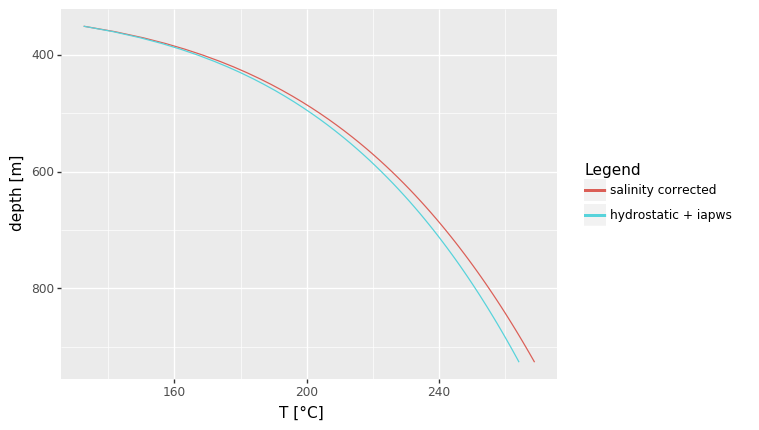

<ggplot: (-9223371851247854176)>

In [92]:
ggplot(aes(y = "depth")) +\
    geom_line(aes(x = "tsat", colour = "'salinity corrected'"), data = sal_df) + \
    geom_line(aes(x = "tsat", colour = "'hydrostatic + iapws'"), data = hyd_df) + \
    scale_y_reverse() + \
    labs(x = "T [°C]", y = "depth [m]", colour = "Legend")

The next method we are going to show is not using PHREEQC but a correlation for NaCl containing brines after Driesner (2007). We first have to define the functions for this correlation:

In [98]:
def driesner_TV(T, P, xNaCl):
    """Volumetric scaling of temperature. After Driesner 2007 II, eq.8 to e.16
    Args:
        temperature (float): scaled temperature for volumetric correlation in Kelvin.
        pressure (float): pressure in bar.
        XNaCl (float): Mole fraction of NaCl
    Returns:
        [type]: [description]
    """
    
   
    xH2O = 1 - xNaCl
    
    # parameters for n1 and n2
    n11 = -54.2958 - 45.7623 * np.exp(-9.44785e-4 * P)
    n21 = -2.6142 - 0.000239092 * P
    n22 = 0.0356828 + 4.37235e-6 * P + 2.0566e-9 * P**2
    
    # parameters for n30 and n31
    n300 = 7.60664e6 / (P + 472.051)**2
    n301 = -50 - 86.1446 * np.exp(-6.21128e-4 * P)
    n302 = 294.318 * np.exp(-5.66735e-3 * P)
    n310 = -0.0732761 * np.exp(-2.3772e-3 * P) - 5.2948e-5* P #changed
    n311 = -47.2747 + 24.3653 * np.exp(-1.25533e-3 * P)
    n312 = -0.278529 - 0.00081381 * P
    n30 = n300 * (np.exp(n301 * xNaCl) - 1) + n302 * xNaCl
    n31 = n310 * np.exp(n311 * xNaCl) + n312 * xNaCl
    
    # calculate eliminations from liquid NaCl equations
    nacl_n1 = 330.47 + 0.942876 * P ** 0.5 + 8.17193e-2 * P - 2.47556e-8 * P ** 2 + 3.45052e-10 * P ** 3 #eq. 11
    n10 = nacl_n1
    n12 = -n11 - n10
    n20 = 1 - n21 * n22 ** 0.5
    nacl_n2 = -0.0370751 + 0.00237723 * P ** 0.5 + 5.42049e-5 * P + 5.84709e-9 * P ** 2 - 5.99373E-13 * P ** 3 #eq. 12
    n23 = nacl_n2 - n20 - n21 * (1 + n22) ** 0.5
    
    # calculate n1 and n2 for eq. 13
    n1 = n10 + n11 * xH2O + n12 * xH2O ** 2 #eq. 9
    n2 = n20 + n21 * (xNaCl + n22) ** 0.5 + n23 * xNaCl # eq. 10
    d = n30 * np.exp(n31 * T)
    
    TV = n1 + n2 * T + d #eq. 13
    
    return(TV)

def molality_to_mole_fraction(molality):
    mw_h2o = 18.015268
    moles_h2o = 1000 / mw_h2o
    mole_fraction = molality / (molality + moles_h2o)
    return mole_fraction

def nacl_equivalents(chem_ions, chem_units = 'mol/kgw'):
    # Calculate NaCl equivalents from major ions
    if chem_units == "mol/kgw":
        kat = chem_ions["Na"] + chem_ions["K"] + chem_ions["Ca"]
        an = chem_ions["Cl"] + chem_ions["SO4"] + chem_ions["HCO3"]
        nacl_molality = float((kat + an)/2)
        
    else:
        warn("Other units not implemented yet")
        return
    
    return nacl_molality

def driesner_rho(T, P, nacl, chem_units = "mol/kgw"):
    '''
    Parameters
    ----------
    T : float
        Temperature in [°C].
    P : float
        Pressure in [bar].
    nacl : float
        NaCl concentraion in unit as specified in unit.
    chem_units : string, optional
        Unit for salinity. The default is "mol/kgw".

    Returns
    -------
    rho : float
          Density in [kg/m3].
    '''
    
    if chem_units == "mol/kgw":
        nacl = molality_to_mole_fraction(nacl)
    elif chem_units == "mole_fraction":
        nacl = nacl
    else:
        warn("Other units not implemented yet")
        return
    mm_H2O = 18.015268
    mm_NaCl = 58.4428
    
    TV = driesner_TV(T, P, nacl)
    TVK = TV +273.15
    
    rho = iapws95_rho(TV+273.15, P*1e5)
    
    '''
    Due to scaled temperature (TV) being sometimes higher than the true temperature,
    the fluid might be in the steam region when supplying values at the saturation pressure.
    For these scenarios, IAPWS would calculate a pressure of the steam phase, which is not what we want.
    We therefore have to increase the pressure to the minimum possible pressure, at which calculation is possible.
    '''
    if rho < 400:
        print("Correcting pressure")
        P = iapws95_Psat(TVK) + 1e-7
        rho = iapws95_rho(TV+273.15, P)
    
    V_h2o = mm_H2O / rho * 1000
    rho = (mm_H2O * (1 - nacl) + mm_NaCl * nacl) / V_h2o * 1000

    return(rho)

    
    

In [106]:
driesner_TV(100, 2, 0.1)
driesner_rho(132.5568,2.91, 1.5, "mol/kgw")

118.35335328837171

989.7387473159187

In [113]:
sal_curve_drie = bpdc_salinity(depth = df["depth_m"][35:],
                p0=df["pres_bara"].min(),
                chem_ions = chem_ions_mol,
                method = "driesner",
                chem_units = "mol/kgw")

sal_df_drie = pd.DataFrame(sal_curve_drie._asdict())
sal_df_drie.head()

DRIESNER


C:\Users\t.hoerbrand\anaconda3\lib\site-packages\ipykernel_launcher.py:190: UserWarning: Step size of depth interval > 1. This leads to an error propagation in calculated temperatures. Consider reducing the interval size.
C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1302: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
C:\Users\t.hoerbrand\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1672: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


,depth,pressure,tsat,rho
0,350.9,2.916018,132.556829,989.738938
1,360.2,3.818986,141.946624,982.185583
2,370.8,4.840322,150.612363,974.949880
3,380.4,5.758491,157.227626,969.253862
4,390.1,6.680803,163.072928,964.095437


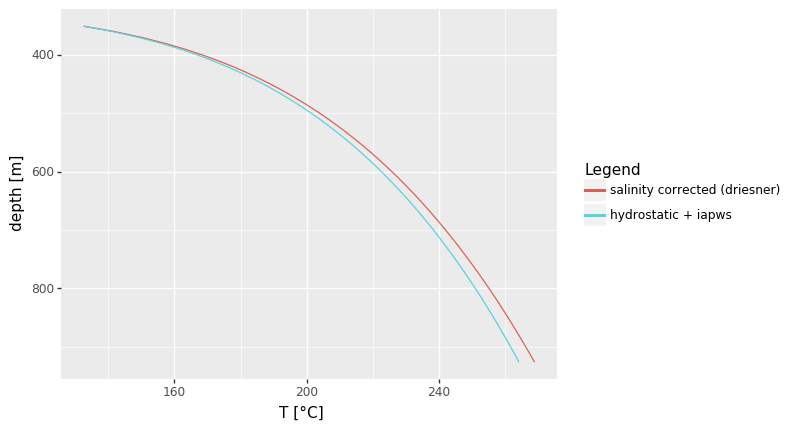

<ggplot: (-9223371851247979832)>

In [86]:
ggplot(aes(y = "depth")) +\
    geom_line(aes(x = "tsat", colour = "'salinity corrected (driesner)'"), data = sal_df) + \
    geom_line(aes(x = "tsat", colour = "'hydrostatic + iapws'"), data = hyd_df) + \
    scale_y_reverse() + \
    labs(x = "T [°C]", y = "depth [m]", colour = "Legend")

,depth,pressure,tsat,rho,diff_rho
0,350.9,2.916018,132.556829,989.512170,-0.022917
1,360.2,3.818779,141.944689,981.906872,-0.028385
2,370.8,4.839825,150.608522,974.654050,-0.030352
3,380.4,5.757715,157.222408,968.970936,-0.029199
4,390.1,6.679759,163.066682,963.846830,-0.025793


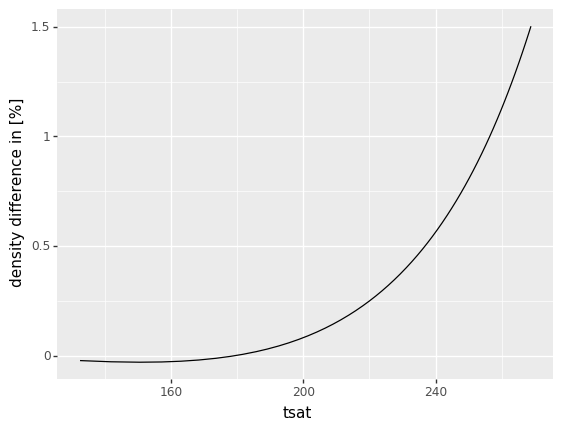

<ggplot: (-9223371851248894300)>

In [116]:
sal_df["diff_rho"] = (sal_df["rho"]-sal_df_drie["rho"])/sal_df["rho"]*100

sal_df.head()

ggplot(sal_df) + geom_line(aes(x = "tsat", y = "diff_rho")) +\
    labs(y = "density difference in [%]")